# 1я модель

In [1]:
import glob
import gzip
import os
import tarfile
import time
import warnings
from urllib.request import urlretrieve

import pandas as pd

import keras
from keras.applications import DenseNet121, ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Flatten
from keras.metrics import AUC
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import os
import numpy as np
import torch
import pandas as pd

import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from read_data import ChestXrayDataSet
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook

import tensorflow as tf
tf.test.is_gpu_available()
from PIL import Image
from torch.autograd import Variable
import re


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
keras.__version__

'2.4.3'

In [3]:
tf.__version__

'2.3.0'

In [4]:
resnet = load_model('resnet-best_new.hdf5', 
                    compile=False)
CLASSES = [
  'Hernia',
  'Pneumonia',
  'Fibrosis',
  'Edema',
  'Emphysema',
  'Cardiomegaly',
  'Pleural_Thickening',
  'Consolidation',
  'Pneumothorax',
  'Mass',
  'Nodule',
  'Atelectasis',
  'Effusion',
  'Infiltration'
]

In [5]:
classes_1 = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']


CKPT_PATH = 'model.pth.tar'
N_CLASSES = 14
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
# DATA_DIR = '../ChestX-ray14/images'
# TEST_IMAGE_LIST = '../ChestX-ray14/labels/test_labels_file_small.txt'



class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


checkpoint = torch.load(CKPT_PATH,map_location='cpu')

pattern = re.compile(
    r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
state_dict = checkpoint['state_dict']

for key in list(state_dict.keys()):
  res = pattern.match(key)
  if res:
      new_key = res.group(1) + res.group(2)
      state_dict[new_key] = state_dict[key]
      del state_dict[key]

model = DenseNet121(N_CLASSES)#.cuda()
model = torch.nn.DataParallel(model)#.cuda()


model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
def ensemble(model_tf,model_to,classes_1,classes_2,ID) ->set:

  img = tf.keras.preprocessing.image.load_img(
    ID, grayscale=False, color_mode='rgb', target_size=None,
    interpolation='nearest'
  )
  

  image_array  = tf.keras.preprocessing.image.img_to_array(img)
  image_array = tf.image.resize(image_array, [224,224])/255
  image_tensor =tf.expand_dims(
    image_array, 0, name=None)
  
  answer_1 = model_tf(image_tensor)
  answ={}
  for cls,pred in (zip(CLASSES,range(len(CLASSES)))):
      answ[cls] = float(answer_1[:,pred])
  max_val = max(answ.values())
  d = []
  for key,val in zip(answ.keys(),answ.values()):
    if val >= max_val*0.6:
      d.append(key)


  normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225])

  image = Image.open(ID)
  image = image.convert('RGB')

  transform=transforms.Compose([
                                      transforms.Resize(224),
                                      transforms.TenCrop(224),
                                      transforms.Lambda
                                      (lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda
                                      (lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                  ])

  inp = transform(image)
  b,c, h, w = inp.size()
  input_var = torch.autograd.Variable(inp.view(-1, c, h, w), volatile=True)
  output = model(input_var)
  answers = set(output.max(1)[1].data.numpy())
  answ=[]
  for i in list(answers):
    answ.append(classes_1[i])
  labels = set(d).union(set(answ))
  result = {'Labels':list(labels),'id':ID}
  return result

      
  

  


In [8]:
os.listdir('.')

['localization',
 'resnet-best_new.hdf5',
 'classifier.py',
 '2000003.png',
 '__pycache__',
 '2000002.png',
 'classifier OLD.py',
 'read_data.py',
 '.ipynb_checkpoints',
 'README.md',
 'Untitled1.ipynb',
 'ChestX-ray14',
 'app.py',
 'image_test.jpg',
 '2000001.png',
 'app (другая копия).py',
 'app (копия).py',
 'images',
 'templates',
 'model.pth.tar',
 '2000000.png',
 'model.py']

In [9]:
ensemble(resnet,model,CLASSES,classes_1,'2000003.png') #../ChestX-ray14/images/00007551_005.png

/home/andrey/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 656.57 MiB already allocated; 75.75 MiB free; 694.00 MiB reserved in total by PyTorch)

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    '../ChestX-ray14/images/00007551_005.png', grayscale=False, color_mode='rgb', target_size=None,
    interpolation='nearest'
  )

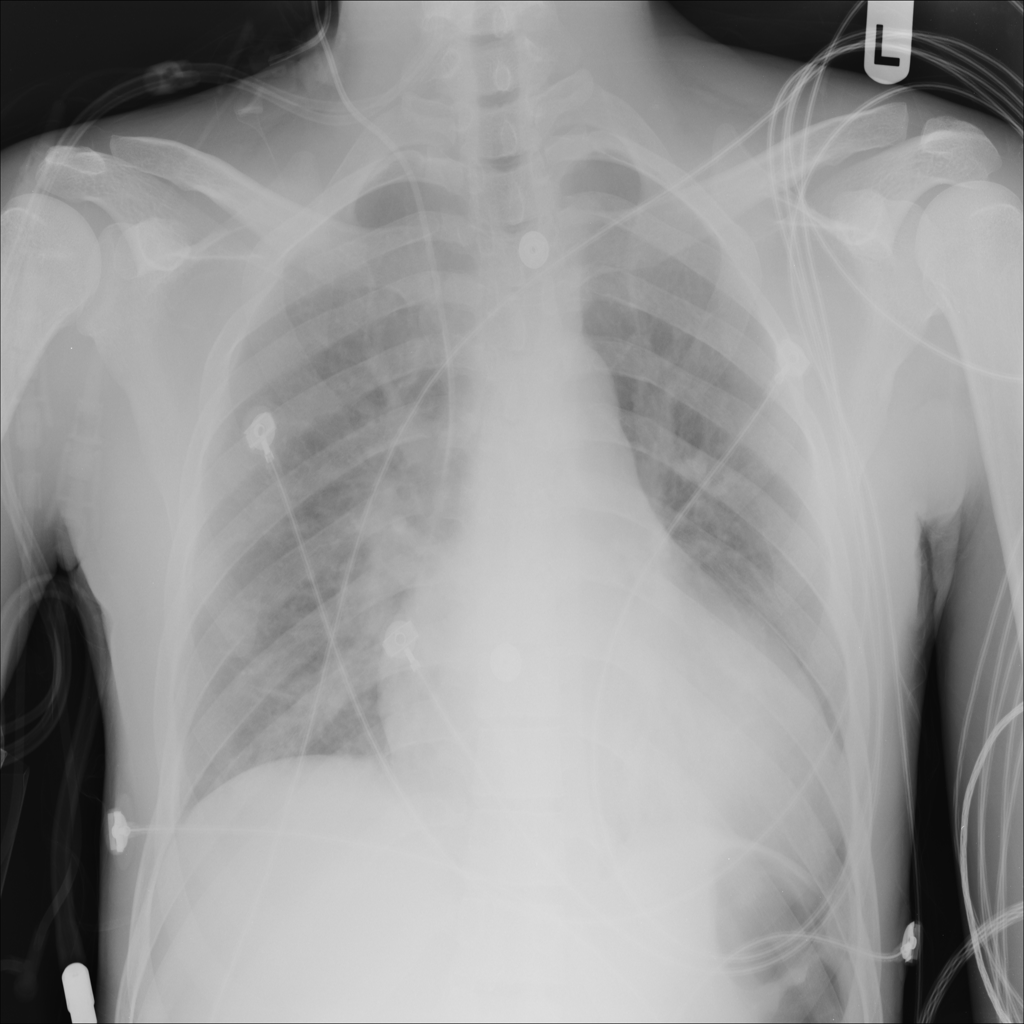

In [ ]:
img

In [ ]:
image = Image.open('../ChestX-ray14/images/00007551_005.png')
image = image.convert('RGB')


In [ ]:
image_array  = tf.keras.preprocessing.image.img_to_array(image)
  

In [ ]:
image_array.shape

(1024, 1024, 3)

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    '../ChestX-ray14/images/00007551_005.png', grayscale=False, color_mode='rgb', target_size=None,
    interpolation='nearest'
  )

In [ ]:
np.array(img).shape

(1024, 1024, 3)